In [1]:
import os

import jax
from jax import jit, grad, jacfwd, vmap
from jax.ops import index, index_update
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import epsilon_0 as eps_0, mu_0


from scripts.loader import load_antenna_el_properties
from scripts.misc import fig_config, rmse, mae
from scripts.nc_utils import (central_difference, holoborodko,
                              elementwise_quad as equad,
                              elementwise_dblquad as edblquad)

In [2]:
# jax config
jax.config.update("jax_enable_x64", True)

In [3]:
# matplotlib config
%config InlineBackend.figure_format = 'retina'
R = 'crimson'
B = 'royalblue'
G = 'mediumseagreen'

# 1 Toy example

Consider a smooth one dimensional function, $f$, written as follows

$$ f(x) = \sin(\sin(2x)), $$ for $x \in [-1, 1]$.

Its first derivative is given in the following analytical expression:

$$ \frac{df}{dx} = 2 \cos(2x) \cos(\sin(2x)), $$

and its second derivative:

$$ \frac{d^2f}{dx} = - 4 \cdot \Big(\sin\big(\sin(2x)\big) \cos^2(2x) + \sin(2x) \cos\big(\sin(2x)\big)\Big).$$

Lets compare two different numerical differentiation approaches, concretely finite differentiation versus automatic differentiation.

In [4]:
def f(x):
    return jnp.sin(jnp.sin(2 * x))

def df(x):
    return 2 * jnp.cos(2 * x) * jnp.cos(jnp.sin(2 * x))

def ddf(x):
    return - 4. * (jnp.sin(jnp.sin(2 * x)) * jnp.cos(2 * x) ** 2
                   + jnp.sin(2 * x) * jnp.cos(jnp.sin(2 * x)))


df_ad = vmap(grad(f))
ddf_ad = vmap(grad(grad(f)))


df_fd = central_difference(f, order=1)
ddf_fd = central_difference(f, order=2)

In [5]:
x = jnp.linspace(-1, 1, 21)
y = f(x)
dy = df(x)
dy_ad = df_ad(x)
dy_fd = df_fd(x)
ddy = ddf(x)
ddy_ad = ddf_ad(x)
ddy_fd = ddf_fd(x)

dy_ad_rmse = rmse(dy, dy_ad)
dy_fd_rmse = rmse(dy, dy_fd)
ddy_ad_rmse = rmse(ddy, ddy_ad)
ddy_fd_rmse = rmse(ddy, ddy_fd)

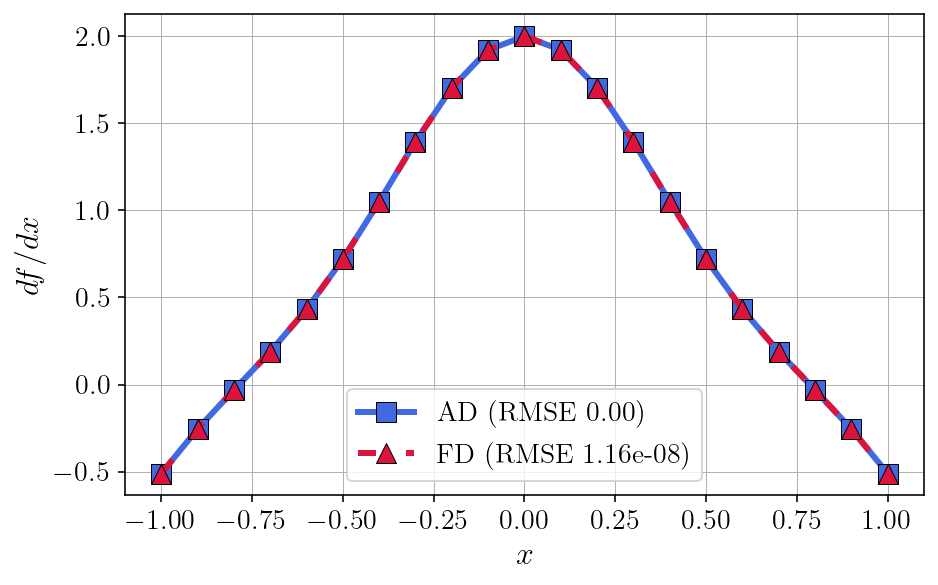

In [6]:
fig_config(latex=True, scaler=1.5)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, dy_ad, 's-', color=B, label=f'AD (RMSE {dy_ad_rmse:.2f})')
ax.plot(x, dy_fd, '^--', color=R, label=f'FD (RMSE {dy_fd_rmse:.2e})')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$df / dx$')
ax.legend()
ax.grid()
plt.show()

In [7]:
fname = 'fig1a'
fig.savefig(os.path.join('figures', f'{fname}.pdf'), transparent=True,
            bbox_inches='tight', pad_inches=0.1)

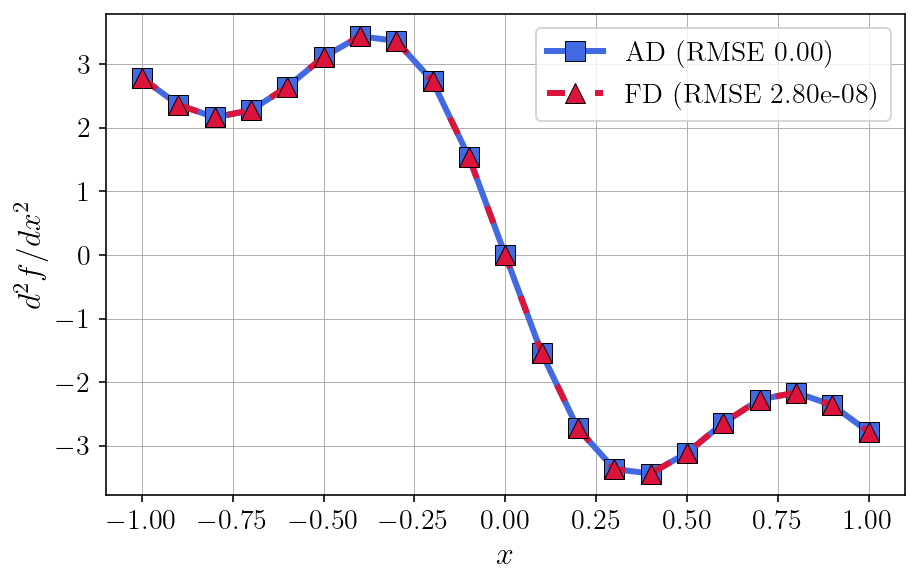

In [8]:
fig_config(latex=True, scaler=1.5)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, ddy_ad, 's-', color=B, label=f'AD (RMSE {ddy_ad_rmse:.2f})')
ax.plot(x, ddy_fd, '^--', color=R, label=f'FD (RMSE {ddy_fd_rmse:.2e})')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$d^2f / dx^2$')
ax.legend()
ax.grid()
plt.show()

In [9]:
fname = 'fig1b'
fig.savefig(os.path.join('figures', f'{fname}.pdf'),
            transparent=True,
            bbox_inches='tight', pad_inches=0.1)

# 2 Working example

Determining incident power density on the human skin model (free space approximation).
The following code demonstrate automatic differentiation capabilitis and its superiority over finite difference scheme when differentiating the Green function in free space in E and H field.

In [10]:
# frequency
f = 10e9

# antenna electric properties (Poljak 2005)
antenna_data = load_antenna_el_properties(f)
Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j
dx = antenna_data.x[1] - antenna_data.x[0]
Is_x = holoborodko(Is, dx)

# antenna position -- coordinates
xs = antenna_data.x.to_numpy()
xs = jnp.asarray(xs)
ys = jnp.zeros_like(xs)
zs = jnp.zeros_like(xs)

# effective radiated skin area
target_area = (0.02, 0.02)  # 2 x 2 cm2
A = target_area[0] * target_area[1]
d = -15 / 1000  # distance from the antenna
N = [21, 21, 21]
xt = jnp.linspace(-target_area[0]/2, target_area[0]/2, N[0]) + xs[-1] / 2
yt = jnp.linspace(-target_area[1]/2, target_area[1]/2, N[1])
zt = jnp.array([d])

## 2.1 Central difference approach

In [11]:
def green_fd(xt, yt, zt, xs, ys, zs, omega):
    k = jnp.sqrt(omega ** 2 * eps_0 * mu_0)
    R = jnp.sqrt((xt - xs) ** 2 + (yt - ys) ** 2 + (zt - zs) ** 2)
    return jnp.exp(-1j * k * R) / R

In [12]:
def efield_fd(xt, yt, zt, xs, ys, zs, Is, Is_x, frequency, delta=1e-4):
    omega = 2 * np.pi * frequency
    gamma = 1j * np.sqrt(omega ** 2 * mu_0 * eps_0)
    prefix = 1 / (1j * 4 * np.pi * omega * eps_0)
    g = green_fd(xt, yt, zt, xs, ys, zs, omega)
    g_x = central_difference(green_fd, axis='x',
                             args=(yt, zt, xs, ys, zs, omega), eps=delta)(xt)
    g_y = central_difference(green_fd, axis='y',
                             args=(xt, zt, xs, ys, zs, omega), eps=delta)(yt)
    g_z = central_difference(green_fd, axis='z',
                             args=(xt, yt, xs, ys, zs, omega), eps=delta)(zt)
    Ex = prefix * (- equad(Is_x * g_x, xs, 3)
                   - gamma ** 2 * equad(Is * g, xs, 3))
    Ey = prefix * (equad(Is_x * g_y, xs, 3))
    Ez = prefix * (equad(Is_x * g_z, xs, 3))
    return (Ex, Ey, Ez)


def hfield_fd(xt, yt, zt, xs, ys, zs, Is, frequency, delta=1e-4):
    omega = 2 * np.pi * frequency
    prefix = 1 / (4 * np.pi)
    g_y = central_difference(green_fd, axis='y',
                             args=(xt, zt, xs, ys, zs, omega), eps=delta)(yt)
    g_z = central_difference(green_fd, axis='z',
                             args=(xt, yt, xs, ys, zs, omega), eps=delta)(zt)
    Hy = prefix * equad(Is * g_z, xs, 3)
    Hz = - prefix * equad(Is * g_y, xs, 3)
    Hx = np.zeros_like(Hz)
    return (Hx, Hy, Hz)

In [13]:
Ex_fd = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
Ey_fd = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
Ez_fd = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
Hx_fd = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
Hy_fd = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
Hz_fd = np.empty((xt.size, yt.size, zt.size), dtype=np.complex128)
for x_idx, _xt in enumerate(xt):
    for y_idx, _yt in enumerate(yt):
        for z_idx, _zt in enumerate(zt):
            _ex, _ey, _ez = efield_fd(_xt, _yt, _zt, xs, ys, zs, Is, Is_x, f)
            _hx, _hy, _hz = hfield_fd(_xt, _yt, _zt, xs, ys, zs, Is, f)
            Ex_fd[x_idx, y_idx, z_idx] = _ex
            Ey_fd[x_idx, y_idx, z_idx] = _ey
            Ez_fd[x_idx, y_idx, z_idx] = _ez
            Hx_fd[x_idx, y_idx, z_idx] = _hx
            Hy_fd[x_idx, y_idx, z_idx] = _hy
            Hz_fd[x_idx, y_idx, z_idx] = _hz

In [14]:
Sinc_fd = np.abs(np.sqrt(np.power(Ex_fd * Hy_fd.conj(), 2)))
Sab_fs_fd = 1 / (2 * A) * edblquad(
    np.real(np.sqrt(np.power(Ex_fd * Hy_fd.conj(), 2))), xt, yt, 31)

## 2.2 Automatic differentiation approach

In [15]:
def green_ad(T, xs, ys, zs, omega):
    k = jnp.sqrt(omega ** 2 * eps_0 * mu_0)
    R = jnp.sqrt((T[0] - xs) ** 2 + (T[1] - ys) ** 2 + (T[2] - zs) ** 2)
    return jnp.exp(-1j * k * R) / R

In [16]:
green_ad = jit(green_ad)
green_jac = jit(jacfwd(green_ad))

In [17]:
def efield_ad(xt, yt, zt, xs, ys, zs, Is, Is_x, frequency):
    omega = 2 * jnp.pi * frequency
    gamma = 1j * jnp.sqrt(omega ** 2 * mu_0 * eps_0)
    prefix = 1 / (1j * 4 * jnp.pi * omega * eps_0)
    g = green_ad(np.asarray([xt, yt, zt]), xs, ys, zs, omega)
    J = green_jac(np.asarray([xt, yt, zt]), xs, ys, zs, omega)
    Ex = prefix * (- equad(Is_x * J[:, 0], xs, 3)
                   - gamma ** 2 * equad(Is * g, xs, 3))
    Ey = prefix * (equad(Is_x * J[:, 1], xs, 3))
    Ez = prefix * (equad(Is_x * J[:, 2], xs, 3))
    return (Ex, Ey, Ez)


def hfield_ad(xt, yt, zt, xs, ys, zs, Is, frequency):
    omega = 2 * jnp.pi * frequency
    prefix = 1 / (4 * jnp.pi)
    J = green_jac(np.asarray([xt, yt, zt]), xs, ys, zs, omega)
    Hy = prefix * equad(Is * J[:, 2], xs, 3)
    Hz = - prefix * equad(Is * J[:, 1], xs, 3)
    Hx = np.zeros_like(Hz)
    return (Hx, Hy, Hz)

In [18]:
Ex_ad = jnp.empty((xt.size, yt.size, zt.size), dtype=jnp.complex128)
Ey_ad = jnp.empty((xt.size, yt.size, zt.size), dtype=jnp.complex128)
Ez_ad = jnp.empty((xt.size, yt.size, zt.size), dtype=jnp.complex128)
Hx_ad = jnp.empty((xt.size, yt.size, zt.size), dtype=jnp.complex128)
Hy_ad = jnp.empty((xt.size, yt.size, zt.size), dtype=jnp.complex128)
Hz_ad = jnp.empty((xt.size, yt.size, zt.size), dtype=jnp.complex128)
for x_idx, _xt in enumerate(xt):
    for y_idx, _yt in enumerate(yt):
        for z_idx, _zt in enumerate(zt):
            _ex, _ey, _ez = efield_ad(_xt, _yt, _zt, xs, ys, zs, Is, Is_x, f)
            _hx, _hy, _hz = hfield_ad(_xt, _yt, _zt, xs, ys, zs, Is, f)
            Ex_ad = index_update(Ex_ad, index[x_idx, y_idx, z_idx], _ex.item())
            Ey_ad = index_update(Ey_ad, index[x_idx, y_idx, z_idx], _ey.item())
            Ez_ad = index_update(Ez_ad, index[x_idx, y_idx, z_idx], _ez.item())
            Hx_ad = index_update(Hx_ad, index[x_idx, y_idx, z_idx], _hx.item())
            Hy_ad = index_update(Hy_ad, index[x_idx, y_idx, z_idx], _hy.item())
            Hz_ad = index_update(Hz_ad, index[x_idx, y_idx, z_idx], _hz.item())

In [19]:
Sinc_ad = np.abs(np.sqrt(np.power(Ex_ad * Hy_ad.conj(), 2)))
Sab_fs_ad = 1 / (2 * A) * edblquad(
    np.real(np.sqrt(np.power(Ex_ad * Hy_ad.conj(), 2))), xt, yt, 31)

## 2.3 Evaluation

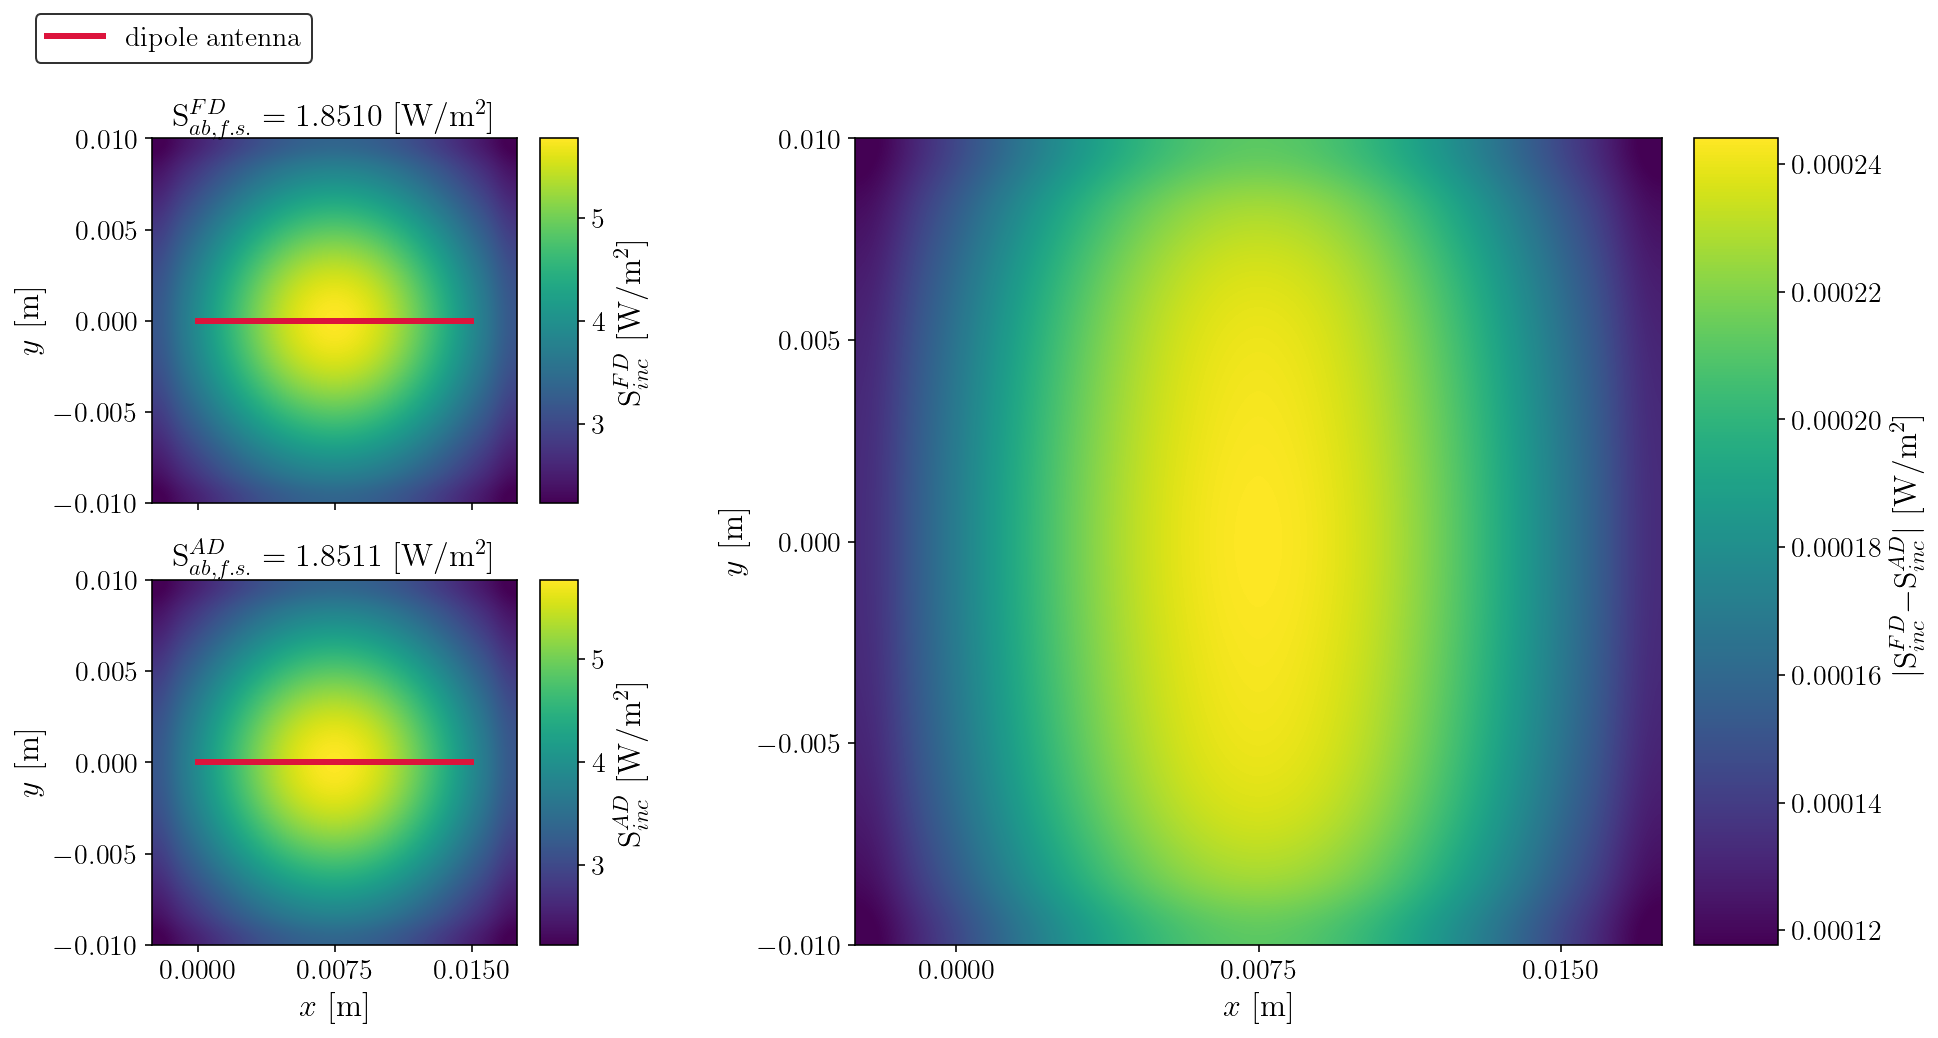

In [20]:
interp = 'spline36'
extent = (xt.min(), xt.max(), yt.min(), yt.max())
difference = np.abs(Sinc_fd - Sinc_ad)

fig_config(latex=True, scaler=1.5)
fig = plt.figure(constrained_layout=True, figsize=(13.5, 6.5))
gs = fig.add_gridspec(nrows=2, ncols=3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[0:, 1:])

cs1 = ax1.imshow(Sinc_fd, interpolation=interp, extent=extent)
cbar1 = fig.colorbar(cs1, ax=ax1)
cbar1.ax.set_ylabel('S$_{inc}^{FD}$ [W/m$^2$]')
ax1.plot(xs, ys, '-', color='crimson', label='dipole antenna')
ax1.set_title(f'S$_{{ab, f.s.}}^{{FD}} = {Sab_fs_fd:.4f}$ [W/m$^2$]')
ax1.set_xticks([0.0, 0.0075, 0.015])
ax1.set_yticks([-0.01, -0.005, 0.0, 0.005, 0.01])
ax1.set_ylabel('$y$ [m]')

cs2 = ax2.imshow(Sinc_ad, interpolation=interp, extent=extent)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar2.ax.set_ylabel('S$_{inc}^{AD}$ [W/m$^2$]')
ax2.plot(xs, ys, '-', color='crimson', linewidth=3)
ax2.set_title(f'S$_{{ab, f.s.}}^{{AD}} = {Sab_fs_ad.item():.4f}$ [W/m$^2$]')
ax2.set_xticks([0.0, 0.0075, 0.015])
ax2.set_yticks([-0.01, -0.005, 0.0, 0.005, 0.01])
ax2.set_xlabel('$x$ [m]')
ax2.set_ylabel('$y$ [m]')

cs3 = ax3.imshow(difference, interpolation=interp, extent=extent)
cbar3 = fig.colorbar(cs3, ax=ax3)
cbar3.ax.set_ylabel('$|$S$_{inc}^{FD} - $S$_{inc}^{AD}|$ [W/m$^2$]')
ax3.set_xticks([0.0, 0.0075, 0.015])
ax3.set_yticks([-0.01, -0.005, 0.0, 0.005, 0.01])
ax3.set_xlabel('$x$ [m]')
ax3.set_ylabel('$y$ [m]')

fig.legend(bbox_to_anchor=(0.175, 1.1), frameon=True, edgecolor='k')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.show()

In [21]:
fname = 'fig2'
fig.savefig(os.path.join('figures', f'{fname}.pdf'),
            transparent=True,
            bbox_inches='tight', pad_inches=0.1)

# 3 Comprehensive simulation

Propagation of the round-off error in central difference scheme over the range of mmWave frequencies.
Automatic differentiation is considered as the ground truth.

In [22]:
target_area = (0.02, 0.02)
A = target_area[0] * target_area[1]
d = -15 / 1000
N = [21, 21, 21]
f_list = [3., 6., 10., 15., 20., 30., 40., 60., 80., 100.]
delta_list = [1e-3, 0.5e-3, 1e-4]

In [23]:
def ad_sim(f):
    omega = 2 * jnp.pi * f
    gamma = 1j * jnp.sqrt(omega ** 2 * mu_0 * eps_0)
    antenna_data = load_antenna_el_properties(f)
    Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j
    Is = jnp.asarray(Is)
    dx = antenna_data.x[1] - antenna_data.x[0]
    Is_x = holoborodko(Is, dx)
    Is_x = jnp.asarray(Is_x)
    xs = antenna_data.x.to_numpy()
    xs = jnp.asarray(xs)
    ys = jnp.zeros_like(xs)
    zs = jnp.zeros_like(xs)
    xt = jnp.linspace(-target_area[0]/2, target_area[0]/2, N[0]) + xs[-1] / 2
    yt = jnp.linspace(-target_area[1]/2, target_area[1]/2, N[1])
    zt = jnp.array([d])
    Sab_dist = jnp.empty((xt.size, yt.size, zt.size))
    for x_idx, _xt in enumerate(xt):
        for y_idx, _yt in enumerate(yt):
            for z_idx, _zt in enumerate(zt):
                g = green_ad(np.asarray([_xt, _yt, _zt]), xs, ys, zs, omega)
                J = green_jac(np.asarray([_xt, _yt, _zt]), xs, ys, zs, omega)
                Ex = (1 / (1j * 4 * jnp.pi * omega * eps_0)
                      * (- equad(Is_x * J[:, 0], xs, 3)
                         - gamma ** 2 * equad(Is * g, xs, 3)))
                Hy = 1 / (4 * jnp.pi) * equad(Is * J[:, 2], xs, 3)
                Sab_dist = index_update(Sab_dist, index[x_idx, y_idx, z_idx],
                    np.real(np.sqrt(np.power(Ex * Hy.conj(), 2))))
    return 1 / (2 * A) * edblquad(Sab_dist, xt, yt, 31)

In [24]:
Sab_fs_ad_list = []
for f in f_list:
    Sab_fs_ad_list.append(ad_sim(f * 1e9))

In [25]:
def fd_sim(f, delta):
    omega = 2 * np.pi * f
    gamma = 1j * np.sqrt(omega ** 2 * mu_0 * eps_0)
    antenna_data = load_antenna_el_properties(f)
    Is = antenna_data.ireal.to_numpy() + antenna_data.iimag.to_numpy() * 1j
    dx = antenna_data.x[1] - antenna_data.x[0]
    Is_x = holoborodko(Is, dx)
    xs = antenna_data.x.to_numpy()
    ys = np.zeros_like(xs)
    zs = np.zeros_like(xs)
    xt = np.linspace(-target_area[0]/2, target_area[0]/2, N[0]) + xs[-1] / 2
    yt = np.linspace(-target_area[1]/2, target_area[1]/2, N[1])
    zt = np.array([d])
    Sab_dist = np.empty((xt.size, yt.size, zt.size))
    for x_idx, _xt in enumerate(xt):
        for y_idx, _yt in enumerate(yt):
            for z_idx, _zt in enumerate(zt):
                g = green_fd(_xt, _yt, _zt, xs, ys, zs, omega)
                g_x = central_difference(green_fd, axis='x',
                    args=(_yt, _zt, xs, ys, zs, omega), eps=delta)(_xt)
                g_z = central_difference(green_fd, axis='z',
                    args=(_xt, _yt, xs, ys, zs, omega), eps=delta)(_zt)
                Ex = (1 / (1j * 4 * np.pi * omega * eps_0)
                      * (- equad(Is_x * g_x, xs, 3)
                         - gamma ** 2 * equad(Is * g, xs, 3)))
                Hy = 1 / (4 * np.pi) * equad(Is * g_z, xs, 3)
                Sab_dist[x_idx, y_idx, z_idx] = np.real(
                    np.sqrt(np.power(Ex * Hy.conj(), 2)))
    return 1 / (2 * A) * edblquad(Sab_dist, xt, yt, 31)

In [26]:
Sab_fs_fd_dict = {}
for delta in delta_list:
    Sab_fs_fd_list = []
    for f in f_list:
        Sab_fs_fd_list.append(fd_sim(f * 1e9, delta))
        Sab_fs_fd_dict[delta] = Sab_fs_fd_list

In [27]:
RMSE_dict = {}
for key, val in Sab_fs_fd_dict.items():
    RMSE_dict[key] = rmse(np.asarray(Sab_fs_ad_list), np.asarray(val))

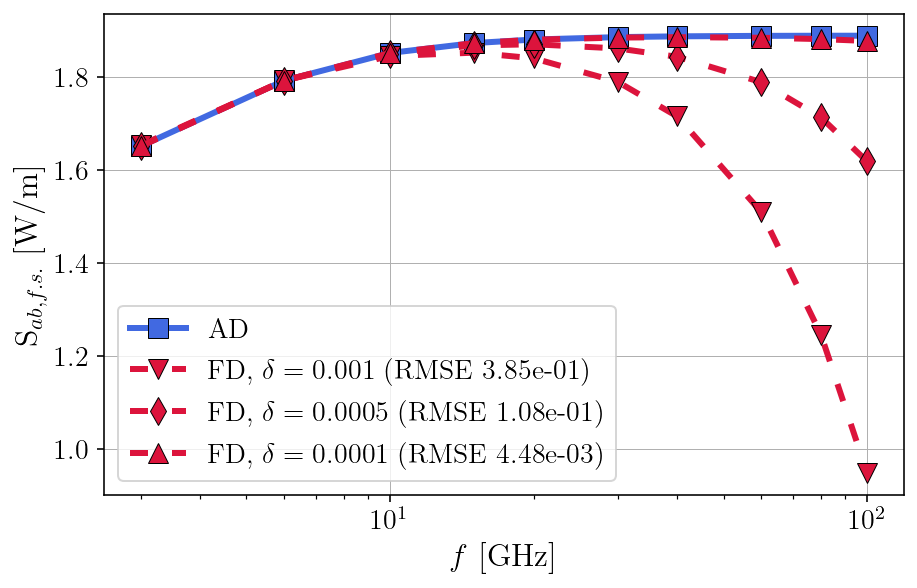

In [28]:
marker_list = ['v', 'd', '^']

fig_config(latex=True, scaler=1.5)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(f_list, Sab_fs_ad_list, 's-', color=B, label=f'AD')
for delta, marker in zip(delta_list, marker_list):
    ax.plot(f_list, Sab_fs_fd_dict[delta], '-', dashes=(3, 4), marker=marker,
            color=R,
            label=f'FD, $\\delta = {delta}$ (RMSE {RMSE_dict[delta]:.2e})')
ax.set_xlabel(r'$f$ [GHz]')
ax.set_ylabel(r'S$_{ab, f.s.}$ [W/m]')
ax.set_xscale('log')
ax.legend()
ax.grid()
plt.show()

In [29]:
fname = 'fig3'
fig.savefig(os.path.join('figures', f'{fname}.pdf'),
            transparent=True,
            bbox_inches='tight', pad_inches=0.1)